## Compte rendu de l'Infrastructure (Groupe 10)
### Étudiante : BELGOUR Aicha Soulef

L'objectif de cette séance est de réalisé l'infrastructure en réel
Les tâches consistaient à configurer les VLANs, établir un accès SSH pour l'administration, configurer le routage Inter-VLAN et permettre l'accès extérieur via NAT/ACL

Ci-dessous se trouve le détail des configurations que nous avons appliquées sur le Switch SW1 et le Routeur R, Ci joint les config complete du Switch et du Routeur

### 1. Configuration des VLANs et assigner les ports sur le Switch

Nous avons configuré le switch (SW1) pour segmenter le réseau en 6 VLANs (10, 20, 30, 40, 50, 60)
Nous avons utilisé des ports en mode accès pour les terminaux et un lien trunk pour la connexion vers le routeur

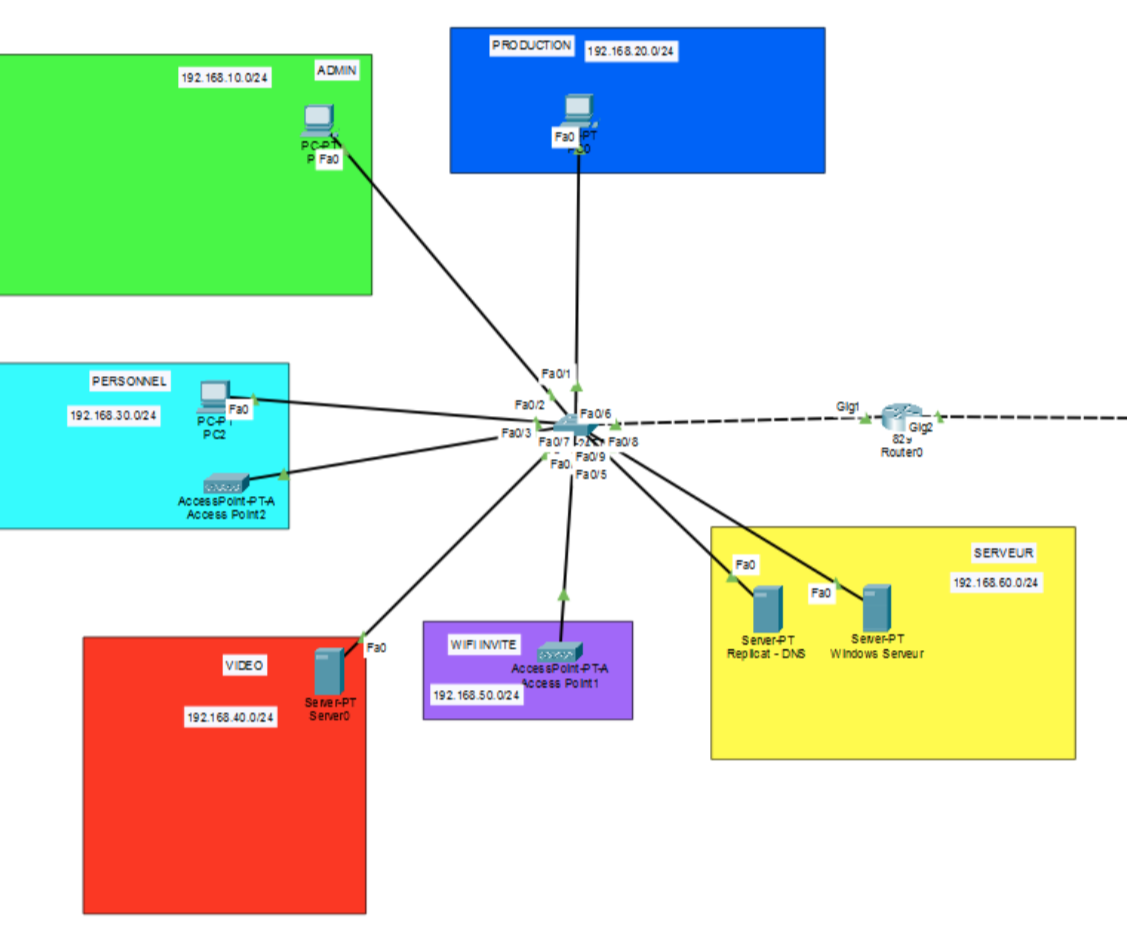

| Zone / VLAN | ID VLAN | Adresse Réseau   | Masque (CIDR) | Passerelle (Gateway) |
| :---        | :---:   | :---             | :---:         | :---                 |
| **ADMIN** | 10      | `192.168.10.0`   | /24           | `192.168.10.254`       |
| **PROD** | 20      | `192.168.20.0`   | /24           | `192.168.20.254`       |
| **PERSO** | 30      | `192.168.30.0`   | /24           | `192.168.30.254`       |
| **VIDEO** | 40      | `192.168.40.0`   | /24           | `192.168.40.254`       |
| **GUEST** | 50      | `192.168.50.0`   | /24           | `192.168.50.254`       |
| **SERVEUR** | 60      | `192.168.60.0`   | /24           | `192.168.60.254`       |

Création et Assignation des ports :

VLAN 10 : Ports Fa0/1 à Fa0/4

VLAN 20 : Ports Fa0/5 à Fa0/8

VLAN 30 : Ports Fa0/9 à Fa0/12

VLAN 40 : Ports Fa0/13 à Fa0/16

VLAN 50 : Ports Fa0/17 à Fa0/20

VLAN 60 : Ports Fa0/21 à Fa0/24

Configuration du Trunk :
Pour permettre le routage Inter-VLAN, nous avons configuré l'interface GigabitEthernet0/1 en mode trunk

In [ ]:
vlan 10
 name VLAN 10
vlan 20
 name VLAN 20
vlan 30
 name VLAN 30
vlan 40
 name VLAN 40
vlan 50
 name VLAN 50
vlan 60
 name VLAN 60
exit

interface FastEthernet0/1
 switchport access vlan 10
 switchport mode access
( la meme chose pour chaque interface tout est mentioné dans Création et Assignation des ports )

interface GigabitEthernet0/1
 switchport trunk allowed vlan 10,20,30,40,50,60
 switchport mode trunk



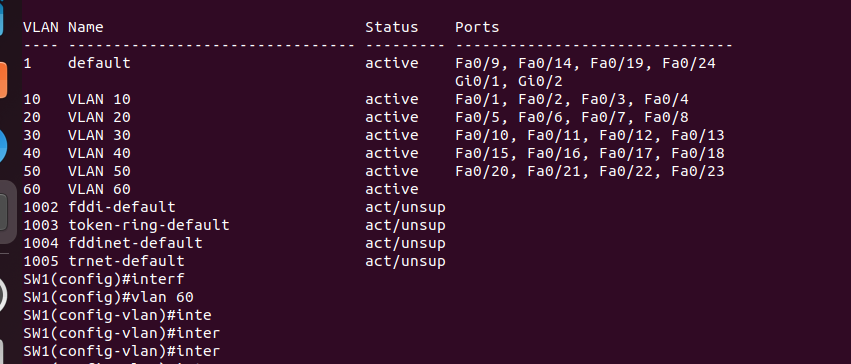

### 2.Configuration SSH

Nous avons sécurisé l'accès au Switch et au Routeur en utilisant SSH version 2
en créant un utilisateur administrateur (groupe10) 

Sécurité du Switch (SW1) :

Configuration du nom de domaine groupe10.local et activation de SSH v2

Création de l'utilisateur groupe10 avec un mot de passe chiffré

Restriction des lignes VTY 0-15 pour n'accepter que le SSH :

In [ ]:

ip domain-name groupe10.local
username groupe10 secret cisco
crypto key generate rsa modulus 1024
ip ssh version 2
line vty 0 15
 login local
 transport input ssh

regler probleme cipher
ssh \
  -oKexAlgorithms=+diffie-hellman-group1-sha1 \
  -oCiphers=+aes128-cbc \
  -oHostKeyAlgorithms=+ssh-rsa \
  -oPubkeyAcceptedAlgorithms=+ssh-rsa \
  groupe10@192.168.10.254

Sécurité du Routeur :

La meme chose avec le domaine entreprise10.local

Application d'une access-class 10 in sur les lignes VTY pour filtrer les IP autorisées à se connecter

In [ ]:
line vty 0 4
 access-class 10 in
 exec-timeout 5 0
 login local
 transport input ssh

### 3.Routage INTER-VLAN & DHCP + Apache2

Configuration des Passerelles :
Nous avons configuré des interfaces logiques pour chaque VLAN afin qu'elles servent de passerelle par défaut :

VLAN 10 : 192.168.10.254 

VLAN 20 : 192.168.20.254 

(La meme chose pour les VLANs 30, 40, 50, 60) 

DHCP :
Le routeur agit comme serveur DHCP pour le LAN il faut la exclure les adresses des passerelles  et créé des pools pour chaque VLAN :

In [ ]:
ip dhcp excluded-address 192.168.10.254
ip dhcp excluded-address 192.168.20.254
ip dhcp excluded-address 192.168.30.254
ip dhcp excluded-address 192.168.40.254
ip dhcp excluded-address 192.168.50.254
ip dhcp excluded-address 192.168.60.254
ip dhcp excluded-address 192.168.60.2
ip dhcp excluded-address 192.168.60.1

ip dhcp pool VLAN_10
 network 192.168.10.0 255.255.255.0
 default-router 192.168.10.254 
 dns-server 172.18.26.101 
(la meme chose pour les VLANs 30, 40, 50, 60 )

#### Mise en place du serveur Web Apache

nous avons installé le serveur Apache puis nous avons vérifié que le service était démarré et aprés modifié la page d'accueil par défaut:

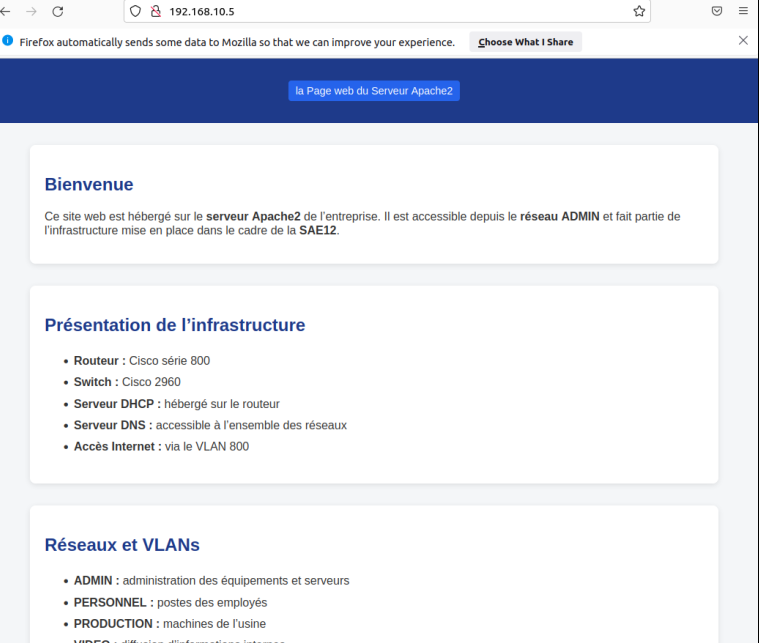

In [ ]:
sudo apt-get update
sudo apt-get install apache2 -y
sudo systemctl status apache2
sudo nano /var/www/html/index.html

### 4. Accès Extérieur, NAT et ACL + (Bonus)
Objectif : Branchement VLAN 800, Capture Extérieur et ACL (Tâches 4 et 5) (vous trouvé ci-joint les trames de WireShark)

Pour permettre l'accès au Serveur Web et au réseau extérieur , nous avons configuré le NAT

Connectivité WAN :
L'interface GigabitEthernet4 a été configurée comme lien WAN avec l'ip 10.10.2.1
Note : Cette interface est définie comme le point de sortie (ip nat outside)
- Adresse ip : 10.11.0.1
- ip route par défaut 0.0.0.0 0.0.0.0 10.0.0.1

NAT  :
Nous avons mappé le trafic interne vers l'interface WAN en utilisant le NAT Overload pour permettre à plusieurs utilisateurs de naviguer au meme temps

### Pourquoi le ping vers l'extérieur ne fonctionnait pas au début ?
Après avoir configuré le routage Inter-VLAN, nous avons tenté de faire un ping vers l'extérieur Nous avons constaté que le ping échouait

- Nos machines possèdent des adresses IP privées
- Grâce à la route par défaut (ip route 0.0.0.0 0.0.0.0 10.0.0.1) nos paquets sortaient bien du routeur

Mais la sur le réseau WAN les adresses privées ne sont pas routables
Le serveur distant recevait notre demande mais essayait de répondre à une adresse privée injoignable

La réponse était donc perdue 

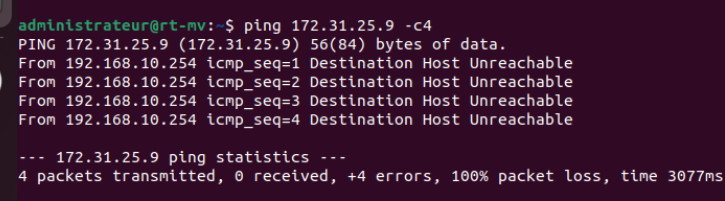

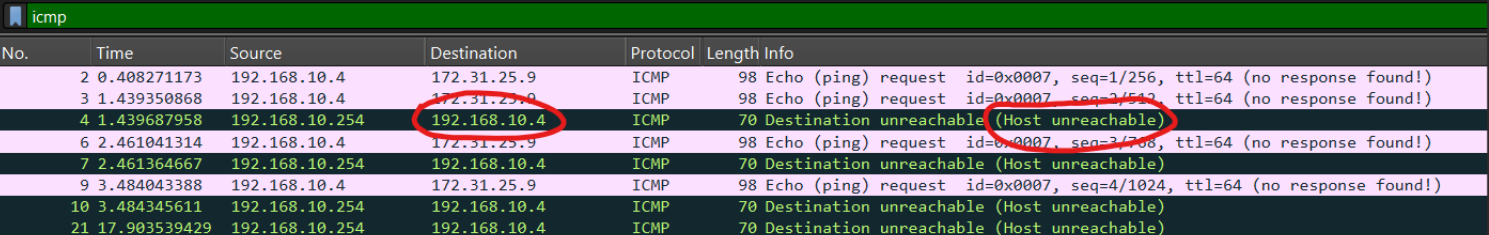

### Comment nous avons résolu le problème avec l'ACL et le NAT
Pour corriger ca nous avons du configurer la Traduction d'Adresse Réseau (NAT)

le NAT a besoin de savoir quel trafic il doit traduire

C'est là que l'ACL intervient (créé une liste d'accès, lié cette ACL à l'interface de sortie WAN)

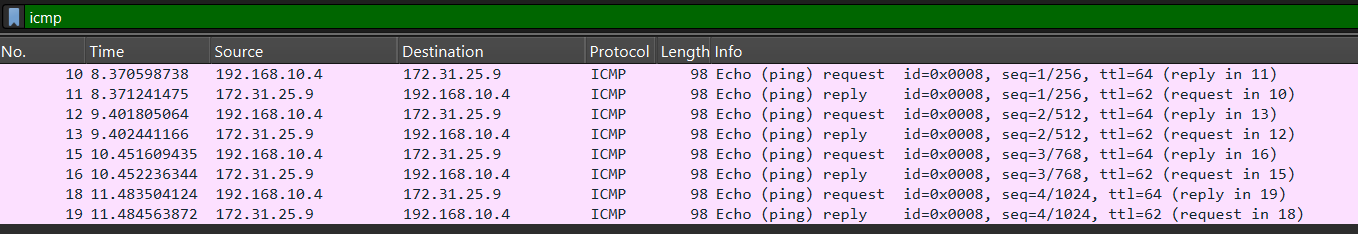

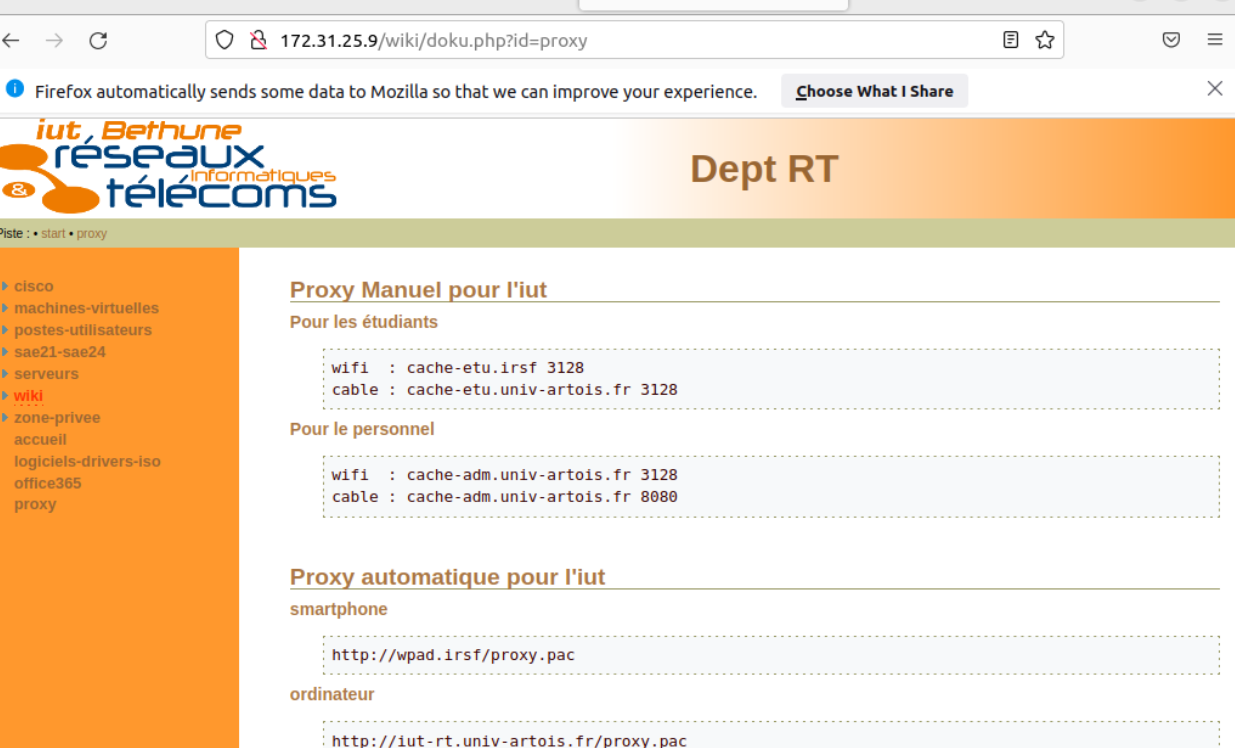


In [ ]:
interface GigabitEthernet4
 ip address 10.10.2.1 255.0.0.0 
 ip access-group 1 in 
 ip nat outside 

In [ ]:
access-list 1 permit 192.168.10.0 0.0.0.255 
access-list 1 permit any 

In [ ]:
ip nat inside source list 1 interface GigabitEthernet4 overload 
ip route 0.0.0.0 0.0.0.0 10.0.0.1 

## Conclusion
L'infrastructure est opérationnelle et les postes dans les VLANs 10 à 60 peuvent recevoir une adresse ip via DHCP et communiquer entre les VLANs grâce au routage, et accéder au réseau extérieur, aussi sécurisé ( SSH et ACL)